Example of how to use *revrand* for regression
==============================================

In this notebook we demonstrate *revrand*'s standard linear model (SLM) and generalised linear model (GLM) fitting a random draw from a GP. We also compare the perfomance of these algorithms to a full GP.


In [1]:
%matplotlib inline

import matplotlib.pyplot as pl
pl.style.use('ggplot')
import numpy as np
import logging

import revrand.legacygp as gp
import revrand.legacygp.kernels as kern
from revrand import StandardLinearModel, GeneralisedLinearModel, likelihoods
from revrand.metrics import msll, smse
from revrand.utils.datasets import gen_gausprocess_se
from revrand.btypes import Parameter, Positive
from revrand import basis_functions as bs
from revrand.optimize import AdaDelta, Adam

# Log output to the terminal attached to this notebook
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)


## Dataset settings and creation

In [2]:
N = 100  # Number of training points
Ns = 250  # Number of test points
lenscale_true = 1.2
noise_true = 0.1

Xtrain, ytrain, Xtest, ftest = \
            gen_gausprocess_se(N, Ns, lenscale=lenscale_true, noise=noise_true)
ytest = ftest + np.random.randn(Ns) * noise_true
    

## Algorithm Settings

In [3]:
# Common settings
nbases = 20  # Number of unique random bases to use for approximating a kernel
lenscale = 1  # Initial value for the lengthscale
noise = 1  # Initial value for target noise
reg = 1  # Initial weight prior

# GLM specific settings
run_glm = True
maxiter = 3000
batch_size = 10
#updater = AdaDelta()
updater = Adam()

# Setup random basis functions
len_ini = Parameter(lenscale, Positive())
base = bs.RandomRBF(Xdim=1, nbases=nbases, lenscale_init=len_ini)


## Parameter learning


In [4]:
# SLM
slm = StandardLinearModel(base,
                          var=Parameter(noise**2, Positive()),
                          regulariser=Parameter(reg, Positive())
                         )
slm.fit(Xtrain, ytrain)

# GLM
if run_glm:
    llhood = likelihoods.Gaussian(var_init=Parameter(noise**2, Positive()))
    glm = GeneralisedLinearModel(llhood,
                                 base,
                                 regulariser=Parameter(reg, Positive()),
                                 batch_size=batch_size,
                                 maxiter=maxiter,
                                 updater=updater
                                 )
    glm.fit(Xtrain, ytrain,)

# GP
def kdef(h, k):
    return (h(1e-5, 1., 0.5) * k(kern.gaussian, h(1e-5, 1e5, lenscale)) +
            k(kern.lognoise, h(-4, 1, -3)))
hyper_params = gp.learn(Xtrain, ytrain, kdef, verbose=True, ftol=1e-6,
                        maxiter=maxiter)
regressor = gp.condition(Xtrain, ytrain, kdef, hyper_params)


      fun: -40.004633531980332
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -1.20792265e-03,   2.82511792e-03,   2.25440431e+01])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 44
      nit: 8
   status: 0
  success: True
        x: (0.8255735662117657, 1.3335423267552908, -4.0)


## Model Querying


In [5]:
# SLM
Ey_e, Vf_e, Vy_e = slm.predict_moments(Xtest)
Sy_e = np.sqrt(Vy_e)
    
# GLM
if run_glm:
    Ey_g, Vf_g, Eyn, Eyx = glm.predict_moments(Xtest)
    Vy_g = Vf_g + glm.like_hypers[0]
    Sy_g = np.sqrt(Vy_g)

# GP
query = gp.query(regressor, Xtest)
Ey_gp = gp.mean(query)
Vy_gp = gp.variance(query, noise=True)
Sy_gp = np.sqrt(Vy_gp)


## Score the models

In [6]:
LL_s = msll(ytest, Ey_e, Vy_e, ytrain)
LL_gp = msll(ytest, Ey_gp, Vy_gp, ytrain)
if run_glm:
    LL_g = msll(ytest, Ey_g, Vy_g, ytrain)

smse_s = smse(ytest, Ey_e)
smse_gp = smse(ytest, Ey_gp)
if run_glm:
    smse_glm = smse(ytest, Ey_g)

print("SLM: msll = {}, smse = {}, noise: {}, hypers: {}"
     .format(LL_s, smse_s, np.sqrt(slm.var), slm.hypers))
print("GP: msll = {}, smse = {}, noise: {}, hypers: {}"
     .format(LL_gp, smse_gp, hyper_params[0], hyper_params[1]))

if run_glm:
    print("GLM: msll = {}, smse = {}, noise: {}, hypers: {}"
         .format(LL_g, smse_glm, np.sqrt(glm.like_hypers[0]),
                 glm.basis_hypers))


SLM: msll = -2.0141904976878964, smse = 0.01814509105110325, noise: 0.10492930188348336, hypers: (1.0151982288149444,)
GP: msll = -1.9927628794545267, smse = 0.01593258077641647, noise: 0.8255735662117657, hypers: 1.3335423267552908
GLM: msll = -1.9152200991646038, smse = 0.019348255382656374, noise: 0.13433421109976448, hypers: (0.9962178537123959,)


## Plot predictions

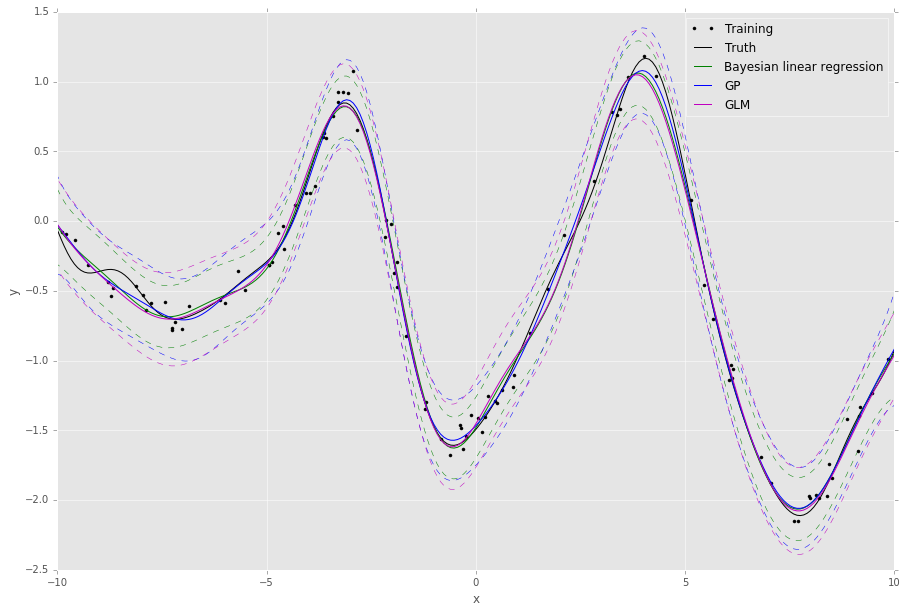

In [7]:
Xpl_t = Xtrain.flatten()
Xpl_s = Xtest.flatten()

# Training/Truth
pl.figure(figsize=(15, 10))
pl.plot(Xpl_t, ytrain, 'k.', label='Training')
pl.plot(Xpl_s, ftest, 'k-', label='Truth')

# ELBO Regressor
pl.plot(Xpl_s, Ey_e, 'g-', label='Bayesian linear regression')
pl.fill_between(Xpl_s, Ey_e - 2 * Sy_e, Ey_e + 2 * Sy_e, facecolor='none',
                edgecolor='g', linestyle='--', label=None)

# GP
pl.plot(Xpl_s, Ey_gp, 'b-', label='GP')
pl.fill_between(Xpl_s, Ey_gp - 2 * Sy_gp, Ey_gp + 2 * Sy_gp,
                facecolor='none', edgecolor='b', linestyle='--',
                label=None)

# GLM Regressor
if run_glm:
    pl.plot(Xpl_s, Ey_g, 'm-', label='GLM')
    pl.fill_between(Xpl_s, Ey_g - 2 * Sy_g, Ey_g + 2 * Sy_g, facecolor='none',
                    edgecolor='m', linestyle='--', label=None)

pl.legend()

pl.grid(True)
pl.ylabel('y')
pl.xlabel('x')

pl.show()
